# A04b: Applied Filtering (Quick Reference)

**Duration**: ~20 minutes

**Prerequisites**: 
- [A04a: Filter Fundamentals](A04a_filter_fundamentals.ipynb)

## Learning Objectives

By the end of this notebook, you will be able to:

1. **Apply filters** to time-series signals using src/filtering.py functions
2. **Handle edge effects** and use zero-phase filtering
3. **Remove powerline noise** using notch filters
4. **Build a complete EEG filtering pipeline**

## Table of Contents

1. [Introduction](#section-1-introduction)
2. [Applying Filters to Signals](#section-2-applying-filters-to-signals)
3. [Edge Effects and Transients](#section-3-edge-effects-and-transients)
4. [Zero-Phase Filtering](#section-4-zero-phase-filtering)
5. [Notch Filtering](#section-5-notch-filtering)
6. [Complete EEG Pipeline](#section-6-complete-eeg-pipeline)
7. [Exercises](#section-7-exercises)
8. [Summary](#summary)
9. [External Resources](#external-resources)
10. [Discussion Questions](#discussion-questions)

---

In [10]:
# =============================================================================
# Imports
# =============================================================================

# Standard library
import sys
from pathlib import Path

# Third-party
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt
from scipy.signal import filtfilt, lfilter
from scipy.fft import fft, fftfreq

# Local imports
src_path = Path.cwd().parents[2]
if str(src_path) not in sys.path:
    sys.path.insert(0, str(src_path))

from src.colors import COLORS
from src.filtering import (
    design_iir_filter,
    design_fir_filter,
    apply_filter,
    notch_filter,
    notch_filter_harmonics,
    mne_filter_data,
)

# Matplotlib configuration
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.figsize"] = (12, 5)
plt.rcParams["font.size"] = 11

print(f"NumPy version: {np.__version__}")
print(f"Source path: {src_path}")

NumPy version: 2.3.5
Source path: /Users/remyramadour/Workspace/PPSP/Workshops/ConnectivityMetricsTutorials


## Section 1: Introduction

In A04a, we learned how to **design** filters. Now we focus on **applying** them to actual signals.

Key challenges when applying filters:
- **Edge effects**: Filters need "warm-up" time, causing artifacts at signal boundaries
- **Phase distortion**: IIR filters shift different frequencies by different amounts
- **Powerline noise**: 50 Hz (Europe) or 60 Hz (US) interference is ubiquitous

For hyperscanning, **zero-phase filtering** is essential to preserve timing relationships between participants.

## Section 2: Applying Filters to Signals

The `apply_filter()` function from `src/filtering.py` provides a simple interface for filtering signals with automatic zero-phase filtering.

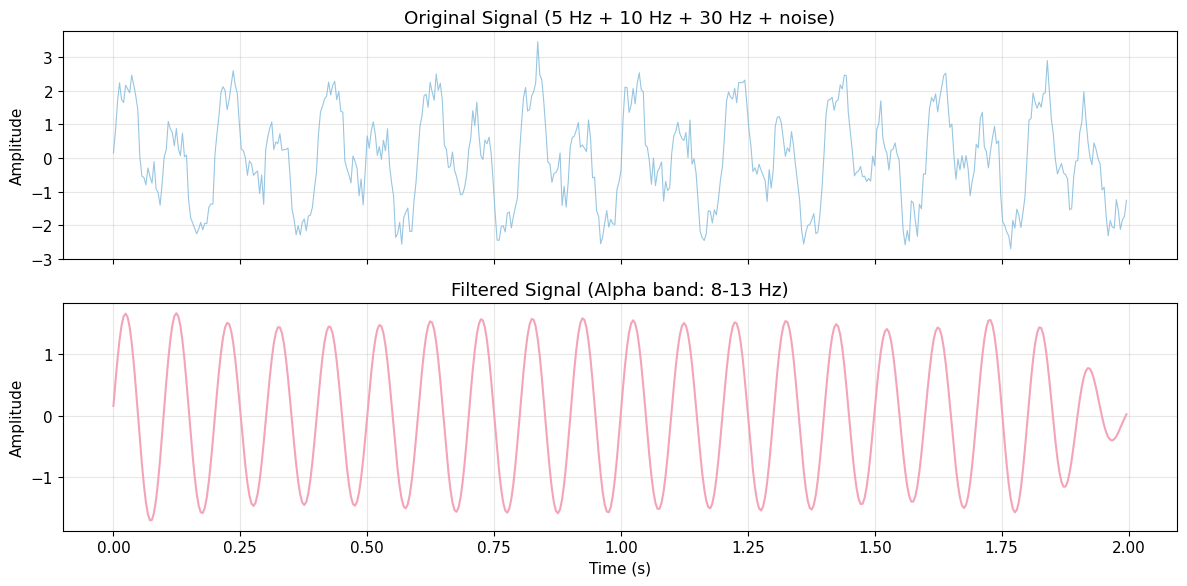

The filter isolated the 10 Hz alpha component.


In [11]:
# =============================================================================
# Section 2: Basic Filter Application
# =============================================================================

# Create a test signal with multiple frequency components
fs = 250  # Hz
duration = 2  # seconds
t = np.arange(0, duration, 1/fs)

# Signal: 5 Hz (theta) + 10 Hz (alpha) + 30 Hz (gamma) + noise
np.random.seed(42)
signal = (
    1.0 * np.sin(2 * np.pi * 5 * t) +   # Theta
    1.5 * np.sin(2 * np.pi * 10 * t) +  # Alpha (strongest)
    0.5 * np.sin(2 * np.pi * 30 * t) +  # Gamma
    0.3 * np.random.randn(len(t))       # Noise
)

# Design and apply a bandpass filter for alpha (8-13 Hz)
b, a = design_iir_filter(cutoff=(8, 13), fs=fs, order=4, btype="band")
filtered = apply_filter(signal, b, a, zero_phase=True)

# Plot
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

axes[0].plot(t, signal, color=COLORS["signal_1"], linewidth=0.8, alpha=0.8)
axes[0].set_ylabel("Amplitude")
axes[0].set_title("Original Signal (5 Hz + 10 Hz + 30 Hz + noise)")
axes[0].grid(True, alpha=0.3)

axes[1].plot(t, filtered, color=COLORS["signal_2"], linewidth=1.5)
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Amplitude")
axes[1].set_title("Filtered Signal (Alpha band: 8-13 Hz)")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("The filter isolated the 10 Hz alpha component.")

## Section 3: Edge Effects and Transients

**Edge effects** occur at signal boundaries because filters need past/future samples. Higher filter orders = longer transients.

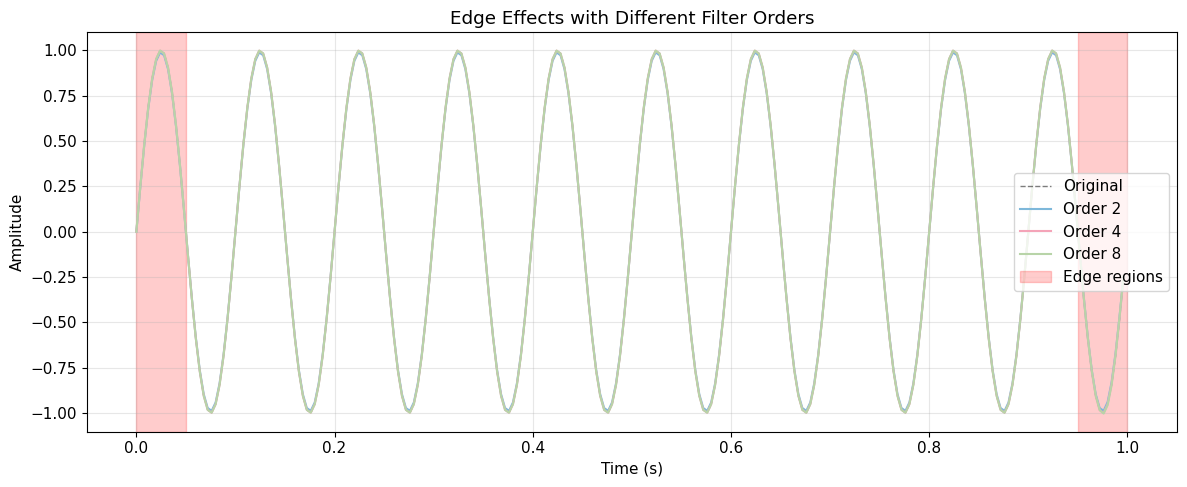

Higher order = sharper cutoff but longer edge effects.


In [12]:
# =============================================================================
# Section 3: Edge Effects Comparison
# =============================================================================

# Create a short signal
fs = 250
duration = 1
t = np.arange(0, duration, 1/fs)
signal = np.sin(2 * np.pi * 10 * t)

# Compare different filter orders
orders = [2, 4, 8]
colors = [COLORS["signal_1"], COLORS["signal_2"], COLORS["signal_3"]]

fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(t, signal, 'k--', linewidth=1, alpha=0.5, label="Original")

for order, color in zip(orders, colors):
    b, a = design_iir_filter(cutoff=30, fs=fs, order=order, btype="low")
    filtered = filtfilt(b, a, signal)
    ax.plot(t, filtered, color=color, linewidth=1.5, label=f"Order {order}")

ax.axvspan(0, 0.05, alpha=0.2, color="red")
ax.axvspan(duration-0.05, duration, alpha=0.2, color="red", label="Edge regions")

ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude")
ax.set_title("Edge Effects with Different Filter Orders")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Higher order = sharper cutoff but longer edge effects.")

## Section 4: Zero-Phase Filtering

**Zero-phase filtering** applies the filter forward then backward, eliminating phase distortion. Essential for connectivity analysis.

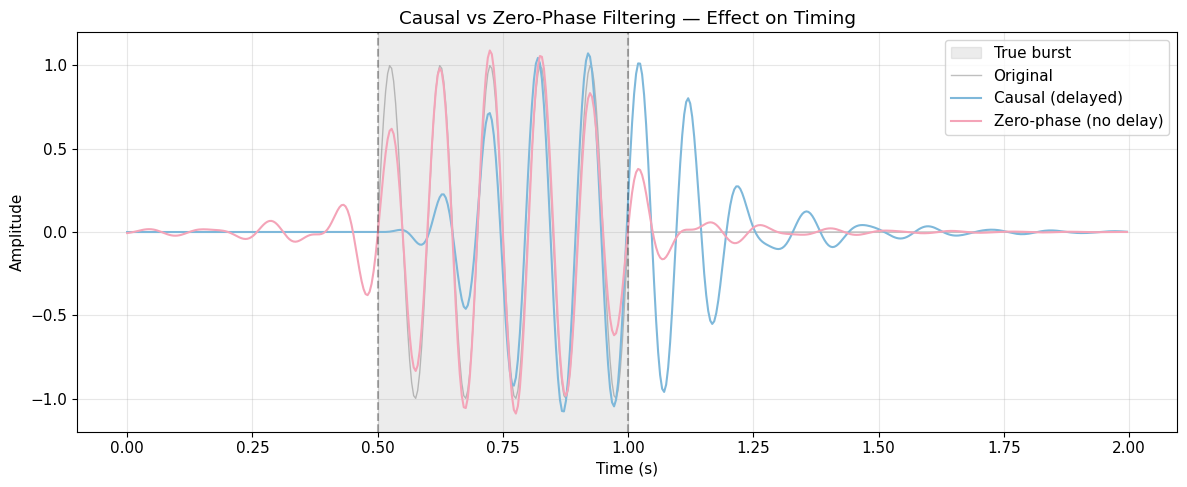

Causal filtering DELAYS the signal.
Zero-phase filtering preserves timing — essential for connectivity!


In [13]:
# =============================================================================
# Section 4: Causal vs Zero-Phase
# =============================================================================

# Create a signal with a burst
fs = 250
duration = 2
t = np.arange(0, duration, 1/fs)

signal = np.zeros_like(t)
burst_start, burst_end = 0.5, 1.0
burst_mask = (t >= burst_start) & (t <= burst_end)
signal[burst_mask] = np.sin(2 * np.pi * 10 * t[burst_mask])

# Apply filter both ways
b, a = design_iir_filter(cutoff=(8, 13), fs=fs, order=4, btype="band")

filtered_causal = lfilter(b, a, signal)
filtered_zerophase = filtfilt(b, a, signal)

# Plot
fig, ax = plt.subplots(figsize=(12, 5))

ax.axvspan(burst_start, burst_end, alpha=0.15, color="gray", label="True burst")
ax.plot(t, signal, color="gray", linewidth=1, alpha=0.5, label="Original")
ax.plot(t, filtered_causal, color=COLORS["signal_1"], linewidth=1.5, label="Causal (delayed)")
ax.plot(t, filtered_zerophase, color=COLORS["signal_2"], linewidth=1.5, label="Zero-phase (no delay)")

ax.axvline(burst_start, color="black", linestyle="--", alpha=0.3)
ax.axvline(burst_end, color="black", linestyle="--", alpha=0.3)

ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude")
ax.set_title("Causal vs Zero-Phase Filtering — Effect on Timing")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Causal filtering DELAYS the signal.")
print("Zero-phase filtering preserves timing — essential for connectivity!")

## Section 5: Notch Filtering

Notch filters remove powerline interference (50 Hz in Europe, 60 Hz in Americas) and their harmonics.

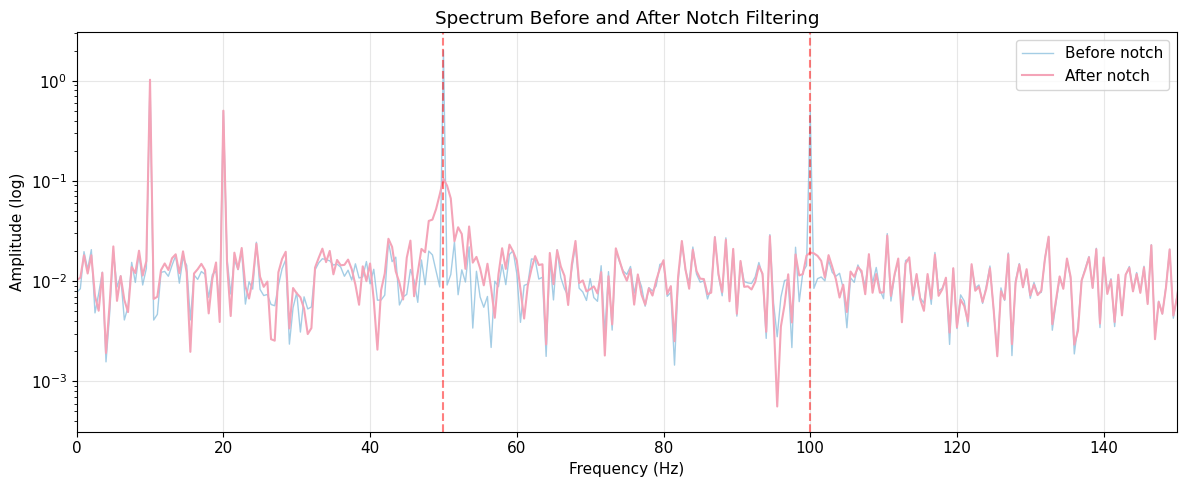

Notch filter removed 50 Hz and 100 Hz interference.


In [14]:
# =============================================================================
# Section 5: Notch Filtering Demo
# =============================================================================

# Create EEG with powerline noise
fs = 500
duration = 2
t = np.arange(0, duration, 1/fs)

np.random.seed(42)
eeg_clean = (
    1.0 * np.sin(2 * np.pi * 10 * t) +   # Alpha
    0.5 * np.sin(2 * np.pi * 20 * t) +   # Beta
    0.2 * np.random.randn(len(t))
)

# Add 50 Hz + 100 Hz interference
powerline = 2.0 * np.sin(2 * np.pi * 50 * t) + 0.5 * np.sin(2 * np.pi * 100 * t)
eeg_noisy = eeg_clean + powerline

# Apply notch filter
eeg_notched = notch_filter_harmonics(eeg_noisy, base_freq=50, fs=fs, n_harmonics=2)

# Plot spectra
n = len(t)
freqs = fftfreq(n, 1/fs)[:n//2]
spectrum_noisy = np.abs(fft(eeg_noisy))[:n//2] * 2 / n
spectrum_notched = np.abs(fft(eeg_notched))[:n//2] * 2 / n

fig, ax = plt.subplots(figsize=(12, 5))

ax.semilogy(freqs, spectrum_noisy, color=COLORS["signal_1"], linewidth=1, alpha=0.7, label="Before notch")
ax.semilogy(freqs, spectrum_notched, color=COLORS["signal_2"], linewidth=1.5, label="After notch")

ax.axvline(50, color="red", linestyle="--", alpha=0.5)
ax.axvline(100, color="red", linestyle="--", alpha=0.5)

ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Amplitude (log)")
ax.set_title("Spectrum Before and After Notch Filtering")
ax.set_xlim(0, 150)
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Notch filter removed 50 Hz and 100 Hz interference.")

## Section 6: Complete EEG Pipeline

A typical pipeline: Notch (50/60 Hz) → Bandpass (0.5-40 Hz)

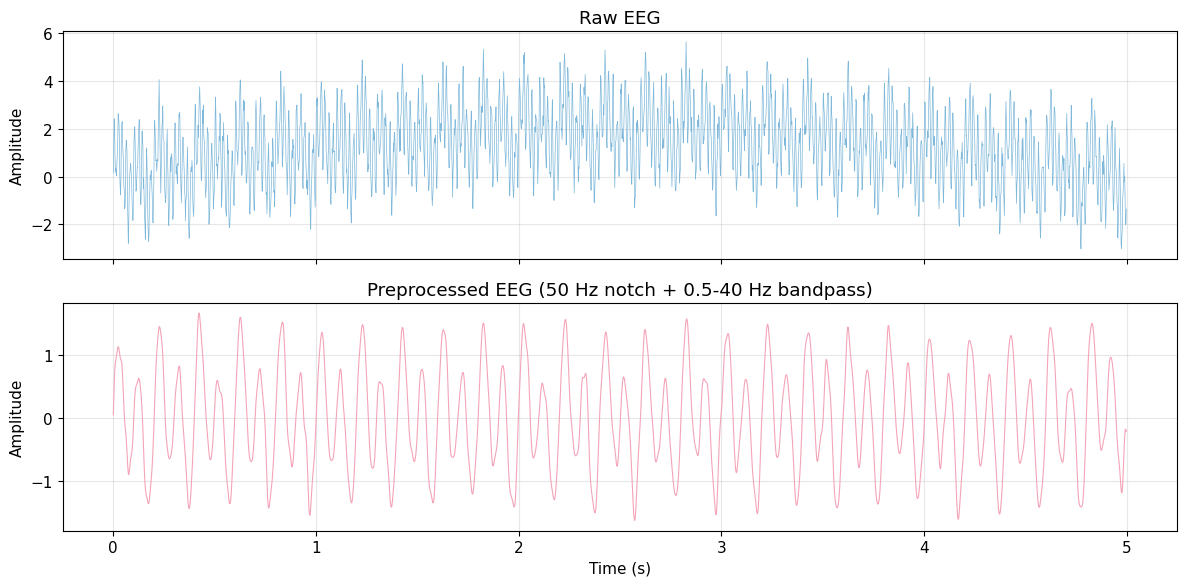

Pipeline: Notch at 50 Hz → Bandpass 0.5-40 Hz


In [15]:
# =============================================================================
# Section 6: Complete Pipeline
# =============================================================================

# Create noisy EEG
fs = 500
duration = 5
t = np.arange(0, duration, 1/fs)

np.random.seed(42)
neural = 1.0 * np.sin(2 * np.pi * 10 * t) + 0.5 * np.sin(2 * np.pi * 5 * t)
slow_drift = 2.0 * np.sin(2 * np.pi * 0.1 * t)
powerline = 1.5 * np.sin(2 * np.pi * 50 * t)
high_freq = 0.5 * np.sin(2 * np.pi * 80 * t)
noise = 0.3 * np.random.randn(len(t))

raw_eeg = neural + slow_drift + powerline + high_freq + noise

# Pipeline: Notch → Bandpass
step1 = notch_filter_harmonics(raw_eeg, base_freq=50, fs=fs, n_harmonics=2)
b, a = design_iir_filter(cutoff=(0.5, 40), fs=fs, order=4, btype="band")
clean_eeg = filtfilt(b, a, step1)

# Plot
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

axes[0].plot(t, raw_eeg, color=COLORS["signal_1"], linewidth=0.5)
axes[0].set_ylabel("Amplitude")
axes[0].set_title("Raw EEG")
axes[0].grid(True, alpha=0.3)

axes[1].plot(t, clean_eeg, color=COLORS["signal_2"], linewidth=0.8)
axes[1].set_xlabel("Time (s)")
axes[1].set_ylabel("Amplitude")
axes[1].set_title("Preprocessed EEG (50 Hz notch + 0.5-40 Hz bandpass)")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Pipeline: Notch at 50 Hz → Bandpass 0.5-40 Hz")

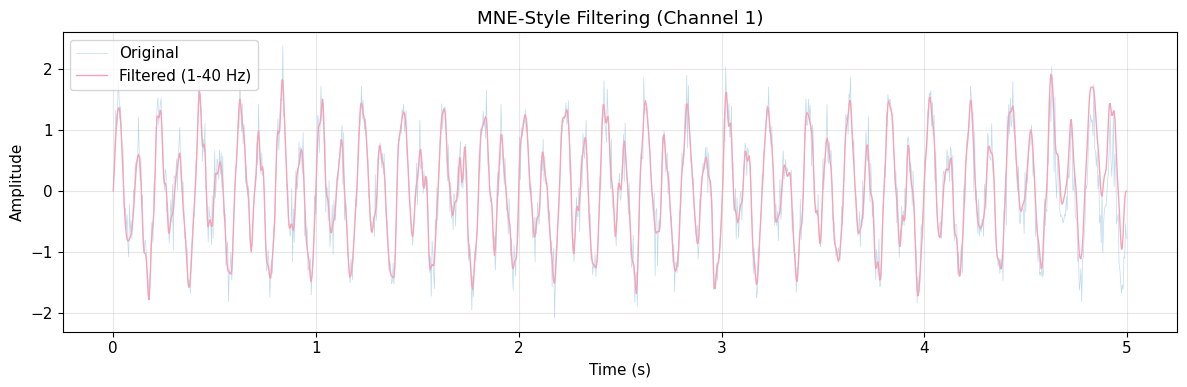

Input shape: (4, 1250) → Output shape: (4, 1250)


In [16]:
# =============================================================================
# Section 6: MNE-Style Filtering
# =============================================================================

# Multi-channel data (4 simulated EEG channels)
fs = 250
duration = 5
n_channels = 4
t = np.arange(0, duration, 1/fs)

np.random.seed(42)
data = np.zeros((n_channels, len(t)))
for i in range(n_channels):
    data[i] = (
        1.0 * np.sin(2 * np.pi * 10 * t + i * np.pi/4) +
        0.5 * np.sin(2 * np.pi * 5 * t) +
        0.3 * np.random.randn(len(t))
    )

# Filter all channels at once
data_filtered = mne_filter_data(data, fs, l_freq=1, h_freq=40)

# Plot
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(t, data[0], color=COLORS["signal_1"], linewidth=0.5, alpha=0.5, label="Original")
ax.plot(t, data_filtered[0], color=COLORS["signal_2"], linewidth=1, label="Filtered (1-40 Hz)")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Amplitude")
ax.set_title("MNE-Style Filtering (Channel 1)")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Input shape: {data.shape} → Output shape: {data_filtered.shape}")

---

<a id="section-7-exercises"></a>
## 7. Exercises

### 🎯 Exercise 1: US Powerline Removal

**Task:** Apply a notch filter at 60 Hz (and harmonics) to remove US powerline noise.

- Create a signal with 60 Hz interference
- Apply `notch_filter_harmonics()` with `base_freq=60`
- Compare before/after in time and frequency domains

```python
# Your code here
fs = 500
duration = 2
t = np.arange(0, duration, 1/fs)

# Create signal with 60 Hz noise
signal_clean = np.sin(2 * np.pi * 10 * t)  # 10 Hz alpha
signal_with_60hz = signal_clean + 0.5 * np.sin(2 * np.pi * 60 * t)

# Remove 60 Hz
# signal_filtered = notch_filter_harmonics(signal_with_60hz, base_freq=60, fs=fs)
```

<details>
<summary>💡 Click to reveal solution</summary>

```python
fs = 500
duration = 2
t = np.arange(0, duration, 1/fs)

# Create signal with 60 Hz noise
signal_clean = np.sin(2 * np.pi * 10 * t)
signal_with_60hz = signal_clean + 0.5 * np.sin(2 * np.pi * 60 * t)

# Remove 60 Hz and harmonics
signal_filtered = notch_filter_harmonics(signal_with_60hz, base_freq=60, fs=fs, n_harmonics=2)

# Plot
fig, axes = plt.subplots(2, 1, figsize=(12, 5), sharex=True)
axes[0].plot(t[:500], signal_with_60hz[:500], color=COLORS["signal_1"])
axes[0].set_title("With 60 Hz noise")
axes[1].plot(t[:500], signal_filtered[:500], color=COLORS["signal_2"])
axes[1].set_title("After notch filter")
axes[1].set_xlabel("Time (s)")
plt.tight_layout()
plt.show()
```

</details>


### 🎯 Exercise 2: Theta Band Extraction

**Task:** Extract the theta band (4-8 Hz) from a noisy signal.

- Design a bandpass filter for theta (4-8 Hz)
- Apply to a signal with multiple frequency components
- Verify theta is isolated

```python
# Your code here
# b, a = design_iir_filter(cutoff=(4, 8), fs=..., order=4, btype="band")
# theta = apply_filter(signal, b, a)
```

<details>
<summary>💡 Click to reveal solution</summary>

```python
fs = 250
duration = 3
t = np.arange(0, duration, 1/fs)

# Multi-component signal
np.random.seed(42)
signal = (
    np.sin(2 * np.pi * 6 * t) +      # Theta (6 Hz)
    np.sin(2 * np.pi * 10 * t) +     # Alpha (10 Hz)
    0.3 * np.random.randn(len(t))    # Noise
)

# Extract theta
b, a = design_iir_filter(cutoff=(4, 8), fs=fs, order=4, btype="band")
theta = apply_filter(signal, b, a)

# Plot
fig, axes = plt.subplots(2, 1, figsize=(12, 5), sharex=True)
axes[0].plot(t, signal, color=COLORS["signal_1"], linewidth=0.5)
axes[0].set_title("Original (theta + alpha + noise)")
axes[1].plot(t, theta, color=COLORS["signal_2"])
axes[1].set_title("Extracted Theta (4-8 Hz)")
axes[1].set_xlabel("Time (s)")
plt.tight_layout()
plt.show()
```

</details>


## Summary

Key takeaways:

- **Zero-phase filtering** (`filtfilt`) preserves timing — essential for connectivity
- **Edge effects** increase with filter order; plan for transients at boundaries
- **Notch filters** remove powerline noise (50/60 Hz and harmonics)
- **Standard pipeline**: Notch → Bandpass (0.5-40 Hz)

### Functions from `src/filtering.py`

| Function | Purpose |
|----------|----------|
| `apply_filter()` | Apply filter with optional zero-phase |
| `notch_filter()` | Remove single frequency |
| `notch_filter_harmonics()` | Remove frequency and harmonics |
| `mne_filter_data()` | MNE-style multi-channel filtering |

### For Hyperscanning

- Always use zero-phase filtering
- Apply identical parameters to both participants
- Handle edge effects when epoching

## External Resources

### 🎧 NotebookLM Resources

- [📺 Video Overview](https://notebooklm.google.com/notebook/5d899740-f497-4339-ac73-909dbf71c3af?artifactId=0af231ba-8877-4cad-b821-f4f25085f345) - Video overview of applied filtering concepts
- [📝 Quiz](https://notebooklm.google.com/notebook/5d899740-f497-4339-ac73-909dbf71c3af?artifactId=bdc62b32-eb64-4961-b1c5-89c1743e3f3b) - Test your understanding
- [🗂️ Flashcards](https://notebooklm.google.com/notebook/5d899740-f497-4339-ac73-909dbf71c3af?artifactId=1ebd1709-713c-49c3-8feb-e077e09c0c57) - Review key concepts

### Documentation
- [SciPy filtfilt](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.filtfilt.html) - Zero-phase filtering
- [MNE-Python filter tutorial](https://mne.tools/stable/auto_tutorials/preprocessing/25_background_filtering.html) - Comprehensive guide

### Scientific Papers
- [Widmann et al. (2015)](https://doi.org/10.1016/j.jneumeth.2014.08.002) - Digital filter design for EEG
- [de Cheveigné & Nelken (2019)](https://doi.org/10.1016/j.neuron.2019.02.039) - When, Why, and How to Filter


## Discussion Questions

1. **Real-time filtering**: In real-time hyperscanning, you can't use `filtfilt()`. What alternatives exist?

2. **Edge effects**: How would you handle filter transients when epoching around events?

3. **Parameter matching**: If two participants have different noise levels, should you use different filter settings?

4. **Notch vs lowpass**: Why use a notch at 50 Hz instead of just lowpass at 49 Hz?